In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import *

In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
%matplotlib inline

In [ ]:
plt.rcParams["figure.figsize"] = 40,10
plt.rcParams["font.size"] = 15

In [ ]:
from one.utils import *
from one.data.ucrdata import UcrDataReader

In [ ]:
ROOT_DIR = "./data/ucr/"
files = get_files_from_path("./data/ucr")

In [ ]:
d = UcrDataReader()
file = d(ROOT_DIR+files[143])

In [ ]:
p = graph_data(file.series, file.labels, file.train_len)

# Experiment

In [ ]:
import os 

from one.utils import *
from one.models import *
from one.data.ucrdata import UcrDataReader

In [ ]:
ROOT_DIR = "./data/ucr/"
SAVE_DIR = "./results/"

SIMPLE_MODELS = [LightGBMModel, RandomForestModel, RegressionModel]
DL_MODELS = [NBEATSModel, NHiTSModel, TCNModel, TFTModel, TransformerModel]
RNN_MODELS = ["RNN", "LSTM", "GRU"]

files = get_files_from_path(ROOT_DIR)

In [ ]:
def run_model(m, data, fdir):
        os.makedirs(fdir, exist_ok=True)
        
        train_data, train_label = data.train
        test_data, test_label = data.test
        
        m.hyperopt_ws(train_data, test_data, 30)

        model_test_data, model_test_label = data.get_test_with_window(m.window)
        
        m.hyperopt_model(train_data, model_test_data, 50)
        m.fit(train_data)

        score, _, preds = m.get_scores(model_test_data)

        save_model_output(score, m, f"{fdir}{m.model_name}_scores.txt")
        save_model_output(preds, m, f"{fdir}{m.model_name}_preds.txt")

In [ ]:
reader = UcrDataReader()

for file in files:
    data_name = file.split(".")[0]
    data = reader(ROOT_DIR+file)
    fdir = f"{SAVE_DIR}{data_name}/"
    
    for model in MODELS:
        m = model()
        run_model(m, data, fdir)
        
    for model in DL_Models:
        m = model(use_gpu=True, val_split=0.1)
        run_model(m, data, fdir)

    for model in RNN_MODELS:
        m = RNNModel(use_gpu=True, rnn_model=model, val_split=0.1)
        run_model(m, data, fdir)
        
        

        

In [ ]:
m.__class__(100)

In [ ]:
m

In [ ]:
from one.models.predictive.nbeats import NBEATSModel

In [ ]:
def hypertune(params: dict):
    w = int(params.get("w"))
    s = int(params.get("s"))
    
    tr_data, tr_label = test.train
    test_data, test_label = test.get_test_with_window(w)
    
    model = NBEATSModel(w, s, True, val_split=max(0.10, (w+s)/len(tr_data)+0.01) )
    model.fit(tr_data)
    score, res, _ = model.get_scores(test_data)
    # return np.average(acf(score, fft=False, nlags=5)).item()
    return np.sum(res**2)


In [ ]:
from hyperopt import fmin, tpe, hp
from statsmodels.tsa.stattools import acf


best = fmin(hypertune,
    space= {'w': hp.quniform("w", 20, 0.2*len(test.train[0]), 5), 
            "s": hp.quniform("s", 1, 20, 1)},
    algo=tpe.suggest,
    max_evals=20)

In [ ]:
best

In [ ]:
w = 160
s = 2

In [ ]:
tr_data, tr_label = test.train
test_data, test_label = test.get_test_with_window(w)

In [ ]:
model = NBEATSModel(w, s, True, val_split=0.15)

In [ ]:
model.fit(tr_data)

In [ ]:
score, res, preds = model.get_scores(test_data)

In [ ]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(score)
a.plot(test.test[1])
b.plot(test.test[0])

In [ ]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(preds)
b.plot(test.test[0])

In [ ]:
import seaborn as sns

sns.distplot(score)

# Scratch

In [ ]:
from one.models import RNNModel

In [ ]:
tr_data, tr_label = test.train
test_data, test_label = test.test

In [ ]:
model = RNNModel()

In [ ]:
model.hyperopt_ws(tr_data, test_data, 2)

In [ ]:
tr_data, tr_label = test.train
test_data, test_label = test.get_test_with_window(model.window)

In [ ]:
model.hyperopt_model(tr_data, test_data, 2)

In [ ]:
model.fit(tr_data)

In [ ]:
score, res, preds = model.get_scores(test_data)

In [ ]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(score)
#a.plot(test.test[1])
b.plot(test.test[0])

In [ ]:
f, (a,b) = plt.subplots(nrows=2)
a.plot(preds)
b.plot(test.test[0])

# PyOD

In [ ]:
from one.models import IsolationForestModel
from numpy.lib.stride_tricks import sliding_window_view
from tods.timeseries_processing import TimeSeriesSeasonalityTrendDecomposition

In [ ]:
clf = IsolationForestModel(1000, 1)

train_series, tr_labels = test.train
test_series, ts_labels = test.test

In [ ]:
clf.fit(train_series)

In [ ]:
pred = clf.get_classification(test_series)

In [ ]:
plt.plot(pred)

In [ ]:
plt.plot(ts_labels)

In [ ]:
p = graph_data(test.test[0], test.test[1], 0)

In [ ]:
seperation = []
trials = [i for i in range(50, 500, 10)]

for w in range(50, 500, 10):
    clf = ECOD()
    tr_windows = sliding_window_view(test.train[0], w)
    clf.fit(tr_windows)
    
    test_data, test_label = test.get_test_with_window(w)
    ts_windows = sliding_window_view(test_data, w)

    pred = clf.decision_function(ts_windows)[:-1]

    sep = np.max(pred) - np.median(pred) 
    
    seperation.append(sep)

In [ ]:
max(seperation)

In [ ]:
dict(zip(seperation, trials))

In [ ]:
w = 490

In [ ]:
    clf = ECOD()
    tr_windows = sliding_window_view(test.train[0], w)
    clf.fit(tr_windows)
    
    test_data, test_label = test.get_test_with_window(w)
    ts_windows = sliding_window_view(test_data, w)

    pred = clf.decision_function(ts_windows)[:-1]

In [ ]:
plt.plot(pred)

In [ ]:
plt.plot(test_label)

# Result Analyzer

In [ ]:
ROOT_DIR = "./data/ucr/"
SAVE_DIR = "./results/"


dirs = get_dirs_from_path(SAVE_DIR)

In [ ]:
from tods.sk_interface.timeseries_processing.HoltWintersExponentialSmoothing_skinterface import (HoltWintersExponentialSmoothingSKI)

In [ ]:
from sklearn.preprocessing import Normalizer

## Set Threshold 

In [ ]:
print(t, t_spot)

In [ ]:
def set_initial_threshold(pct_anom: float, scores) -> float:
    #sort data
    x = np.sort(scores)

    #calculate CDF values
    y = 1. * np.arange(len(scores)) / (len(scores) - 1)
    idx = (np.abs(y - pct_anom)).argmin()

    return x[idx]

def get_peak_set(t: float, scores):
    x = scores.copy()
    x = x[x > t]
    return x - t
    
def get_gpd_param(peak_set):
    y = peak_set.copy()
    mu = y.mean()
    var_y = y.var(ddof=1)
    
    sigma = mu/2 * (1 + mu ** 2 / var_y)
    gamma = 1/2 * (1 - mu ** 2 / var_y)
    
    return sigma, gamma

def get_anomaly_threshold(q, scores, initial_pct_anom = 0.98):
    t = set_initial_threshold(initial_pct_anom, scores)
    y = get_peak_set(t, scores)
    n_y = len(y)
    n = len(scores)
    sigma, gamma = get_gpd_param(y)
        
    new_threshold = t + sigma/gamma * ((q*n/n_y)**(-gamma) - 1)
    return new_threshold

## Panelty

In [ ]:
def _eval_wo_label(df: pd.DataFrame) -> Tuple:
    """
    Returns a few quantitative metrics for us to use for evaluation when labels
    are not provided.
    Parameters
    -----------
    df: pd.Dataframe
        the dataframe with 'timestamp', 'value' and 'predict' columns
        where 'predict' is 1 for those predicted as anomalous and 0 otherwise.
    Returns
    ----------
    tuple
        (number of anomalies,
        % of anomnalies,
        avg. distance between mean and all anomalies (yaxis),
        avg. time distance between consecutive anomalies,
        avg. cycle distance between consecutive anomalies,
        maximum range between non anomaly points (yaxis)
        )
    """

    num_anomalies = df.predict.sum()
    percent_anomalies = num_anomalies/len(df)

    mean_val = df.value.mean()

    pred_anomalies = df[df['predict'] == 1]
    pred_non_anomalies = df[df['predict'] == 1]

    avg_anom_dist_from_mean_val = np.mean(pred_anomalies['value'].apply(lambda x: np.abs(x - mean_val)))
    try:
        avg_time_delta_between_anomalies = pred_anomalies.timestamp.diff().mean().total_seconds() / 3600
    except:
        avg_time_delta_between_anomalies = np.nan
    avg_cycles_delta_between_anomalies = pred_anomalies.index.to_series().diff().fillna(0).mean()

    max_range_non_anomalies = abs(pred_non_anomalies['value'].max() - pred_non_anomalies['value'].min())

    return (num_anomalies,
            percent_anomalies,
            avg_anom_dist_from_mean_val,
            avg_time_delta_between_anomalies,
            avg_cycles_delta_between_anomalies,
            max_range_non_anomalies)

def get_unlabeled_metrics(s: pd.Series, anomalies: pd.Series) -> tuple:
    """
    Helper function to format inputs before getting metrics
    Parameters
    -----------
    s: pd.Series containing values of time series with timestamp as the index
    anomalies: pd.Series containing whether this point is anomalous or not with timestamp as the index, same as above.
    Returns
    ----------
    tuple
        (number of anomalies,
        % of anomnalies,
        avg. distance between mean and all anomalies (yaxis),
        avg. time distance between consecutive anomalies,
        avg. cycle distance between consecutive anomalies,
        maximum range between non anomaly points (yaxis)
        )
    """
    df_res = pd.concat((s, anomalies), axis=1).reset_index()
    df_res.columns = ['timestamp', 'value', 'predict']
    df_res['predict'] = df_res['predict'].astype(int)

    metrics = _eval_wo_label(df_res)

    return metrics

In [ ]:
def compute_objective(values, targets, predicted_anomalies):
    pred = predicted_anomalies.astype(int)

    (num_anomalies, percent_anomalies, avg_anom_dist_from_mean_val, avg_time_delta_between_anomalies,
         avg_cycles_delta_between_anomalies, max_range_non_anomalies) = get_unlabeled_metrics(values, predicted_anomalies)

    obj = 1e4 * percent_anomalies + max_range_non_anomalies - avg_cycles_delta_between_anomalies

    # If nan, should return number in case it always gives nan
    if np.isnan(obj):
        obj = 1e10
    return obj

## Visualization

In [377]:
DATA_DIR = "./data/ucr/"
SAVE_DIR = "./results/"

raw_dirs = get_dirs_from_path(SAVE_DIR)

In [378]:
dirs = get_dirs_from_path(SAVE_DIR)
dirs = [SAVE_DIR + d + "/" for d in dirs]

results = []
for d in dirs:
    for r in get_files_from_path(d):
        if "preds" in r: results.append(d+r)

In [379]:
files = get_files_from_path(DATA_DIR)

In [446]:
result_n = 162

# get original Data
for idx, f in enumerate(files):
    if result_n == int(f.split("_")[0]):
        file = UcrDataReader()(DATA_DIR+f)

# Get experiment outcomes
for idx, f in enumerate(raw_dirs):
    if result_n == int(f.split("_")[0]):
        results = []
        for r in get_files_from_path(dirs[idx]):
            if "scores" in r: results.append(dirs[idx]+r)

In [447]:
anomaly_indices = []

for r in results:
    train_len = int(r.split("_")[4])
    
    arr = np.loadtxt(r)
    th = get_anomaly_threshold(1e-3, arr)
    
    is_anom = arr.copy()
    
    anomaly_indices.append([i + train_len for i in np.where(arr > th)[0]])

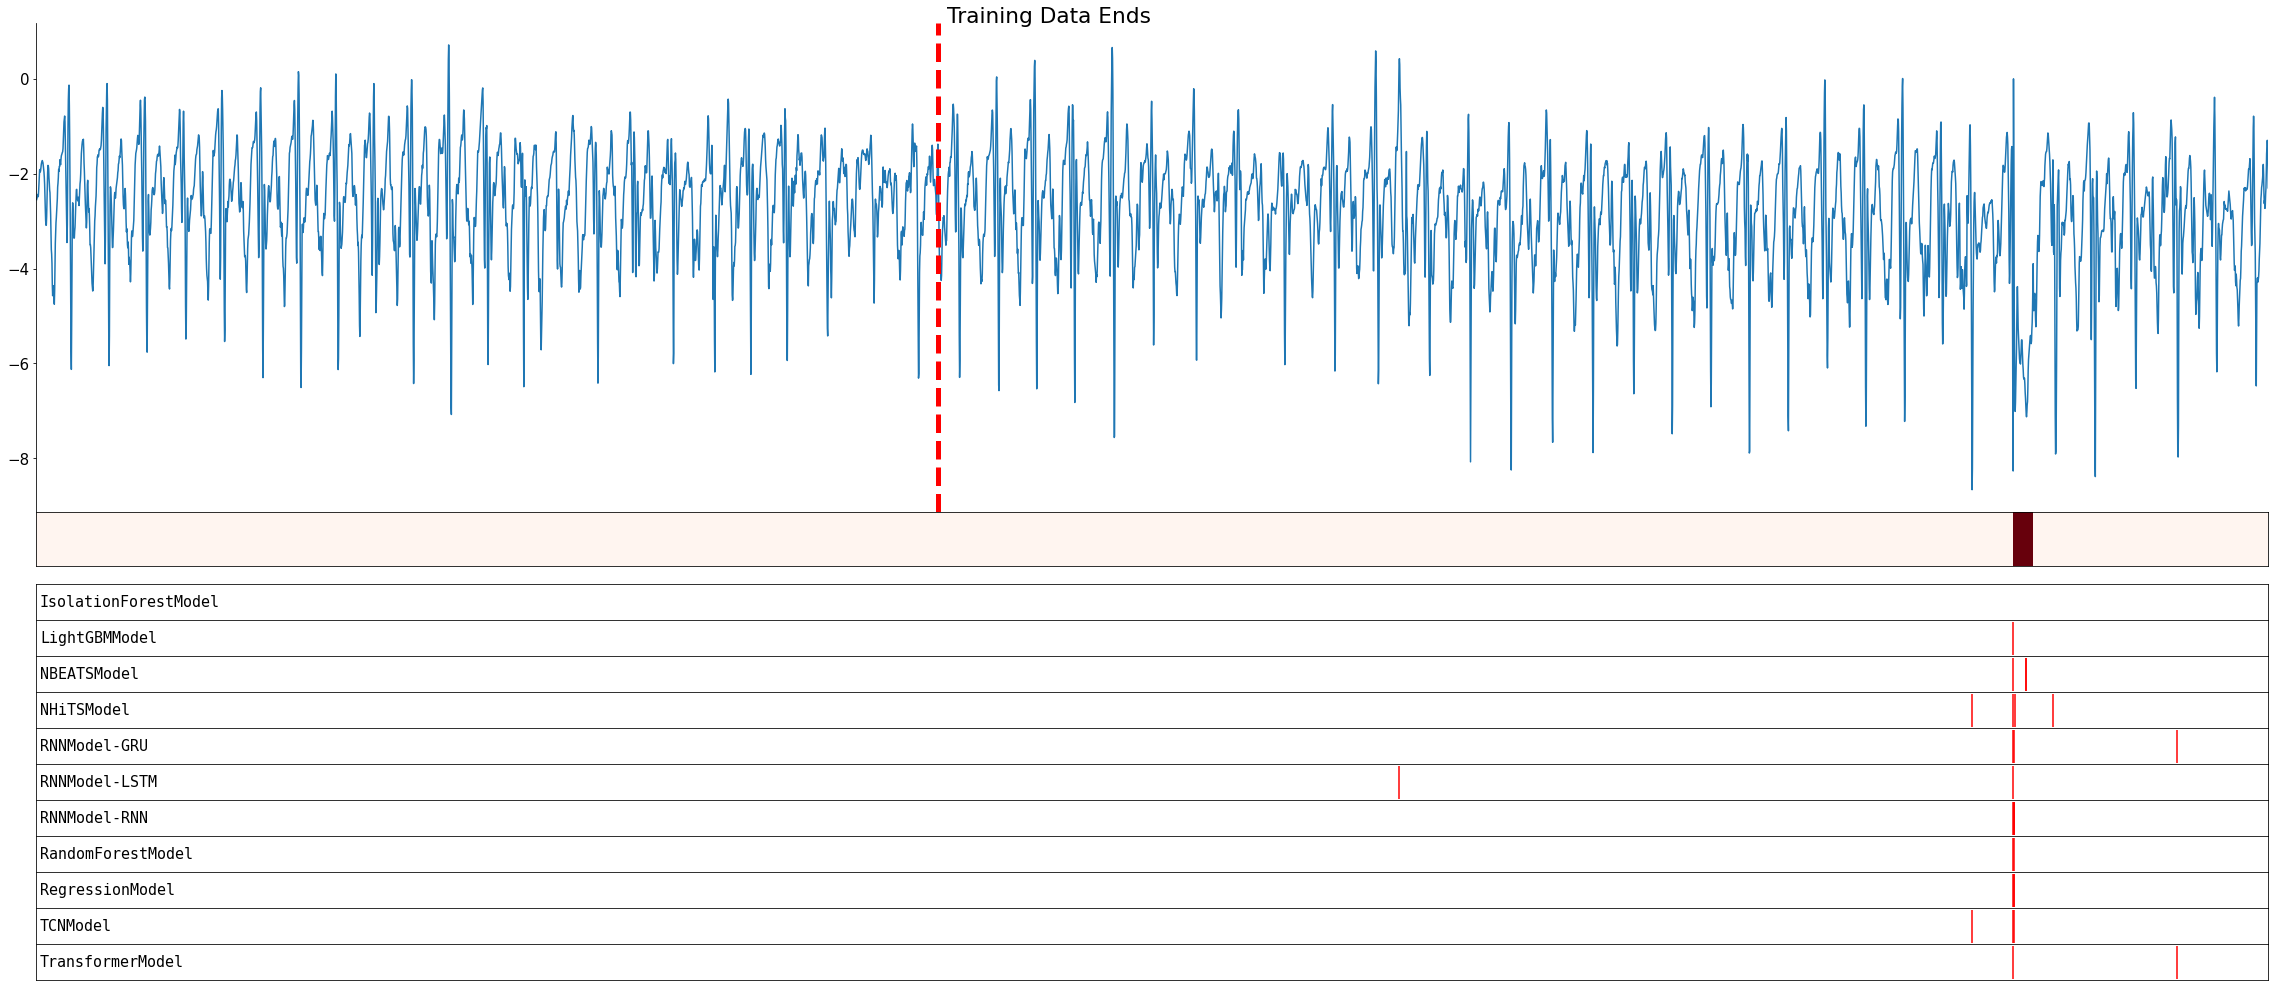

In [448]:
p = graph_data(file.series, file.labels, file.train_len)
ax1, ax2 = p.get_axes()

for idx, anoms in enumerate(anomaly_indices):
    method_name = results[idx].split("/")[-1].split(".")[0].split("_")[0]
    if "RNN" in method_name: method_name += f"-{results[idx].split('/')[-1].split('.')[0].split('_')[1]}"
    
    ax_new = p.add_axes([0.125,0.1 - (1+idx)*(0.05),0.775,0.05], anchor="SW", sharex=ax1)
    ax_new.text(10,0.5, method_name, fontfamily="monospace", va="center")
    
    ax_new.set_xticklabels([])
    ax_new.set_xticks([])
    ax_new.set_yticklabels([])
    ax_new.set_yticks([])
    
    ax_new.vlines(anoms, 0, 1, colors="red")

## Scores

In [454]:
all_f = []
for d in dirs:
    for f in get_files_from_path(d):
        if "preds" in f:
            continue
        all_f.append(d+f)
        
ground_truth = {}
for a in raw_dirs:
    info = a.split("_")
    t_id, train_len, anom_start, anom_end = info[0], info[4], info[5], info[6]
    
    file = UcrDataReader()(DATA_DIR+a+".txt")
    
    data = {"t_id": int(t_id), "train_len": int(train_len), "test_len": len(file.test[0]), "anom_start": int(anom_start), "anom_end": int(anom_end)}
    ground_truth[a] = data


stats = {}    
for f in all_f:
    tp, tn, fp, fn = 0, 0, 0, 0
    
    f_name = f.split("/")[2]
    model_name = f.split("/")[-1].split("_")[0]
    if "RNN" in model_name: model_name += f"-{f.split('/')[-1].split('_')[1]}"
    
    train_len, test_len = ground_truth[f_name]["train_len"], ground_truth[f_name]["test_len"]
    anom_start, anom_end = ground_truth[f_name]["anom_start"], ground_truth[f_name]["anom_end"]
    
    arr = np.loadtxt(f)
    th = get_anomaly_threshold(1e-3, arr)
    
    is_anom = arr.copy()
    
    anom_indices = [i + train_len for i in np.where(arr > th)[0]]
    
    anom_len = anom_end-anom_start+1
    match = sum(anom_indices.count(i) for i in range(anom_start-100, anom_end+100+1))
    if match > 0: tp += anom_len
    else: fn += anom_len
    fp += len(anom_indices) - match
    tn += test_len - tp - fn - fp
       
    try: stats[model_name]
    except KeyError: stats[model_name] = {}

    try: stats[model_name]["tp"] += tp 
    except KeyError: stats[model_name]["tp"] = tp
    try: stats[model_name]["tn"] += tn 
    except KeyError: stats[model_name]["tn"] = tn
    try: stats[model_name]["fp"] += fp
    except KeyError: stats[model_name]["fp"] = fp
    try: stats[model_name]["fn"] += fn
    except KeyError: stats[model_name]["fn"] = fn
   

In [478]:
scores = pd.DataFrame(stats).transpose()
scores

,tp,tn,fp,fn
IsolationForestModel,60,93680,62,2511
LightGBMModel,1914,93715,27,657
NBEATSModel,1914,93722,20,657
NHiTSModel,2107,93724,18,464
RandomForestModel,1914,93725,17,657
RegressionModel,1914,93717,25,657
TCNModel,1914,88774,16,425
RNNModel-LSTM,915,55006,22,1165
RNNModel-RNN,1352,54999,29,728
TransformerModel,1513,55007,21,567


In [486]:
pct = scores.copy()
pct['tp'] = scores['tp'] / (scores['fn'] + scores['tp'])
pct['tn'] = scores['tn'] / (scores['tn'] + scores['fp'])
pct['fp'] = scores['fp'] / (scores['fp'] + scores['tn'])
pct['fn'] = scores['fn'] / (scores['fn'] + scores['tp'])
pct

,tp,tn,fp,fn
IsolationForestModel,0.023337,0.999339,0.000661,0.976663
LightGBMModel,0.744457,0.999712,0.000288,0.255543
NBEATSModel,0.744457,0.999787,0.000213,0.255543
NHiTSModel,0.819525,0.999808,0.000192,0.180475
RandomForestModel,0.744457,0.999819,0.000181,0.255543
RegressionModel,0.744457,0.999733,0.000267,0.255543
TCNModel,0.818298,0.999820,0.000180,0.181702
RNNModel-LSTM,0.439904,0.999600,0.000400,0.560096
RNNModel-RNN,0.650000,0.999473,0.000527,0.350000
TransformerModel,0.727404,0.999618,0.000382,0.272596


In [487]:
metrics = pct.copy()

metrics["precision"] = metrics['tp']/(metrics['tp'] + metrics['fp'])
metrics["recall"] = metrics['tp']/(metrics['tp'] + metrics['tn'])
metrics["f1"] = 2 *  (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'])

metrics.drop(["tp", "tn", "fp", "fn"], axis=1)

,precision,recall,f1
IsolationForestModel,0.972440,0.022820,0.044593
LightGBMModel,0.999613,0.426826,0.598218
NBEATSModel,0.999713,0.426808,0.598218
NHiTSModel,0.999766,0.450454,0.621076
RandomForestModel,0.999756,0.426800,0.598218
RegressionModel,0.999642,0.426821,0.598218
TCNModel,0.999780,0.450080,0.620723
RNNModel-LSTM,0.999092,0.305594,0.468031
RNNModel-RNN,0.999190,0.394065,0.565217
TransformerModel,0.999476,0.421190,0.592636
